# Sigmoid Activation and Binary Crossentropy - A Less Than Perfect Match?
### Investigating concerns of numerical imprecision
This and similarly named notebooks contain calculations and illustrations of an article published on Towards Data Science in February 2019 to be found here:
https://towardsdatascience.com/sigmoid-activation-and-binary-crossentropy-a-less-than-perfect-match-b801e130e31. The explanatory prose corresonds largely to a draft version of the published article, plus a few post-publication comments.

### Part 2: Checking raw values
This code expects the existence of trained network models saved into hdf5 files. See src/models/train_model.py and the Makefile.

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, layers, optimizers, utils
import sys, os
# path to current project
sys.path.append("/mnt/hd_internal/hh/projects_DS/numeric_precision/")
from src.models.predict_model import get_activations
from src.models.data_gen import get_ImageDataGenerator
from src.models.metrics_for_keras import bce_from_raw, raw_values, sigmoids, binary_accuracy_from_raw, contorted_binary_crossentropy
# other paths needed
fig_dir = "/mnt/hd_internal/hh/projects_DS/numeric_precision/reports/figures/"
train_dir = "/mnt/hd_internal/hh/projects_DS/numeric_precision/data/cats_vs_dogs_small/train"
validation_dir = "/mnt/hd_internal/hh/projects_DS/numeric_precision/data/cats_vs_dogs_small/validation"
test_dir = "/mnt/hd_internal/hh/projects_DS/numeric_precision/data/cats_vs_dogs_small/test"
model_dir = "/mnt/hd_internal/hh/projects_DS/numeric_precision/models"

num_samples_train = 2000;
num_samples_val = 1000

Using TensorFlow backend.


In [2]:
# font sizes
plt.rcParams['font.size'] = 12
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
# other text parameters
plt.rcParams['text.usetex'] = False # True activates latex output in fonts!
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth}, \\usepackage{type1cm}"
# lines
#plt.rcParams['lines.linewidth'] = 2.0
#plt.rcParams['lines.markersize'] = 8
# resolution of saved graphics
plt.rcParams['savefig.dpi'] = 300

In [3]:
# select trained, saved model
model_name = "convnet01_raw_epoch200_2019_03_01_19-29.hdf5"
#model_name = "VGG16_imagenet_raw_epoch200_2019_03_01_19-56.hdf5"
#model_name = "InceptionV3_imagenet_raw_epoch200_2019_03_01_20-21.hdf5"

custom_objects = {"bce_from_raw": bce_from_raw,
                  "raw_values": raw_values,
                  "sigmoids": sigmoids,
                  "binary_accuracy_from_raw": binary_accuracy_from_raw,
                  "contorted_binary_crossentropy": contorted_binary_crossentropy}

In [4]:
model = models.load_model(os.path.join(model_dir, model_name), custom_objects)
# optional: produce a figure of model architecture
utils.plot_model(model, to_file=os.path.join(fig_dir, "current_model.png"))

In [5]:
# set up imagedatagenerator
eval_batch_size = 1
img_data_gen = get_ImageDataGenerator(train_dir, batch_size=eval_batch_size, doImageTransform=False)
# evaluate, obtaining all metrics and last layer activations
val, metrics_names, min_max_examples = get_activations(model_dir + "/" + model_name, custom_objects, img_data_gen, num_step=2000 // eval_batch_size)

Found 2000 images belonging to 2 classes.


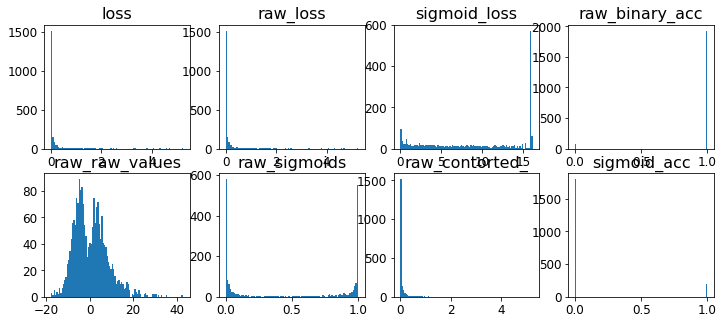

In [6]:
# plot distribution of all metrics (makes sense only for part of them)
fh = plt.figure(figsize=(12,5))
for k in range(len(metrics_names)):
    plt.subplot(2,4,k+1)
    plt.hist(val[:, k], bins=100);
    plt.title(metrics_names[k][:14])

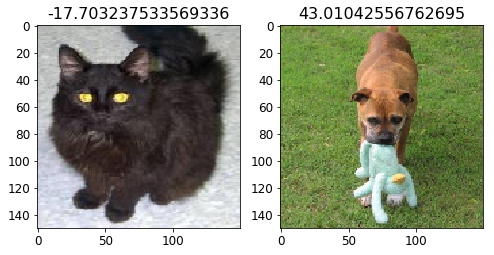

In [7]:
# show images of the cattiest cat and the doggiest dog
fh = plt.figure(figsize=(8,4))
axh1 = plt.subplot(1,2,1)
axh1.imshow(min_max_examples[1])
plt.title(str(min_max_examples[0]))
axh2 = plt.subplot(1,2,2)
axh2.imshow(min_max_examples[3])
plt.title(str(min_max_examples[2]));

/home/hh/miniconda3/envs/airbus_anomaly_detection/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


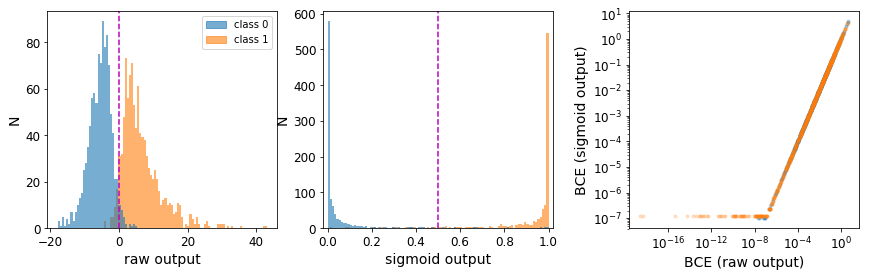

In [8]:
# plot distribution of last layer outputs - raw and sigmoid
# MAKES SENSE ONLY FOR BATCH SIZE = 1
num_bin = 100
class0_ix = val[:, -1] == 0
class1_ix = val[:, -1] == 1

fh = plt.figure(figsize=(14,4))

# plot histogram of last layer input values
m_ix1 = metrics_names.index("raw_raw_values")
axh1 = plt.subplot(1,3,1)
plt.hist([val[class0_ix, m_ix1], val[class1_ix, m_ix1]], bins=num_bin, histtype='stepfilled', alpha=0.6);
xmin, xmax, ymin, ymax = plt.axis()
axh1.vlines(0, 0, ymax, color='m', linestyles='--', linewidth=1.5)
plt.axis((xmin, xmax, ymin, ymax))
plt.xlabel("raw output", fontsize=14)
plt.ylabel("N", fontsize=14)
#plt.title("Last layer output (raw)");
# define artists for the legend
ph1 = matplotlib.patches.Patch([], [], color="tab:blue", alpha=0.6)
ph2 = matplotlib.patches.Patch([], [], color="tab:orange", alpha=0.6)
axh1.legend([ph1, ph2],["class 0", "class 1"])

# also, plot sigmoid-squashed representation
m_ix2 = metrics_names.index("raw_sigmoids")
axh2 = plt.subplot(1,3,2)
plt.hist([val[class0_ix, m_ix2], val[class1_ix, m_ix2]], bins=num_bin, histtype='stepfilled', alpha=0.6);
xmin, xmax, ymin, ymax = plt.axis()
axh2.vlines(0.5, 0, ymax, color='m', linestyles='--', linewidth=1.5)
plt.axis((-0.02, 1.02, ymin, ymax))
plt.xlabel("sigmoid output", fontsize=14)
plt.ylabel("N", fontsize=14)
#plt.title("Last layer output (sigmoid activation)");

# scatter plot of sigmoid-derived loss vs raw-derived loss
m_ix1 = metrics_names.index("raw_loss")
m_ix2 = metrics_names.index("raw_contorted_binary_crossentropy")
axh3 = plt.subplot(1,3,3)
plt.loglog(val[class0_ix, m_ix1], val[class0_ix, m_ix2], linestyle="None", marker=".", color="tab:blue", alpha=0.2);
plt.loglog(val[class1_ix, m_ix1], val[class1_ix, m_ix2], linestyle="None", marker=".", color="tab:orange", alpha=0.2);
plt.xlabel("BCE (raw output)", fontsize=14)
plt.ylabel("BCE (sigmoid output)", fontsize=14)
#axh3.set_aspect("equal","box")
# shift axis a bit to the right
left, bottom, width, height = axh3.get_position().bounds
axh3.set_position([left+0.03, bottom, width, height])
plt.savefig(fig_dir + "last_layer_input_batchsize" + str(eval_batch_size) + "_" + model_name + ".png", format="png")

(1, 20, 1, 20)

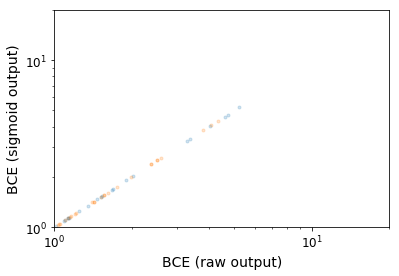

In [9]:
# scatter plot of sigmoid-derived loss vs raw-derived loss - detail of high values
m_ix1 = metrics_names.index("raw_loss")
m_ix2 = metrics_names.index("raw_contorted_binary_crossentropy")

plt.loglog(val[class0_ix, m_ix1], val[class0_ix, m_ix2], linestyle="None", marker=".", color="tab:blue", alpha=0.2);
plt.loglog(val[class1_ix, m_ix1], val[class1_ix, m_ix2], linestyle="None", marker=".", color="tab:orange", alpha=0.2);
plt.xlabel("BCE (raw output)", fontsize=14)
plt.ylabel("BCE (sigmoid output)", fontsize=14)
plt.axis((1, 20, 1, 20))